### Importing libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import time

import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn import model_selection
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score,roc_auc_score,roc_curve
from sklearn.metrics import classification_report
from sklearn.svm import SVC

from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Data import
model_data = pd.read_csv("/home/jovyan/work/Machine_Learning/elm_assignment/input/model_data_final.csv")


### Data preprocessing

#### Data loading & preparations

In [5]:
model_data["datetime"] = pd.to_datetime(model_data["inspection_date"])
model_data["class_label"] = model_data.label.apply(lambda x: 1 if x == 2 else 0)
model_data.sort_values("datetime", inplace=True)
df=model_data.drop(columns='label').copy()

df = df.drop(['license','facility_type', 'inspection_date', 'datetime'], axis = 1)
df.dropna(inplace=True)
df=df.set_index('inspection_id')

In [6]:
df.head(3)

,pass_flag,fail_flag,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,...,pv_70,time_since_last,first_record,age_at_inspection,burglary_kde,temperature_max,humidity,precip_intensity,wind_speed,class_label
inspection_id,,,,,,,,,,,,,,,,,,,,,
626348,1,0,0,0,0,0,0,0,0,0,...,0,2.000000,1,1.382615,18.237634,21,91,12.7,11,0
545724,1,0,0,0,0,0,0,0,0,0,...,0,1.716632,0,3.214237,24.050009,21,91,12.7,11,1
659845,0,0,0,1,1,0,0,0,0,0,...,0,2.000000,1,0.988364,21.058573,21,91,12.7,11,0


#### Standardization 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='class_label'), df['class_label'],
    test_size=0.20, random_state=1,
)

In [10]:
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

### SOLUTION-4

#### Feature Engineering



In [11]:
select_feature = SelectKBest(chi2, k=15).fit(X_train_scaled, y_train)
x_train_s4=select_feature.transform(X_train_scaled)
x_test_s4 = select_feature.transform(X_test_scaled)

#### Class Imbalance

In [12]:
sm = SMOTE(random_state = 42)
X_train_oversampled_s4, y_train_oversampled_s4 = sm.fit_sample(x_train_s4, y_train)
pd.Series(y_train_oversampled_s4).value_counts().sort_index()

0    46820
1    46820
Name: class_label, dtype: int64

#### Modeling & Prediction

##### SVM HyperOpt (Parameter tuning)

In [12]:
best_score=1.0

def objective(space):
    
    global best_score
    model = SVC(**space)   
    kfold = StratifiedKFold(n_splits=kFoldSplits, random_state=seed, shuffle=True) # KFold is also an option.
    score = 1-cross_val_score(model, X_train_oversampled_s4, y_train_oversampled_s4, cv=kfold, scoring=metric, verbose=False).mean() 
    # Careful here (score). The objective function will be  minimized, thus somme treatment on your score might be needed.
    
    if (score < best_score):
        best_score=score
    
    return score 

space = {
      'C': hp.choice('C', np.arange(0.005,1.0,0.1)),
      'kernel': hp.choice('kernel',['poly', 'rbf']),
      'degree':hp.choice('degree',[2,3,4]),
      'probability':hp.choice('probability',[True])
      }

n_iter_hopt = 10
seed = 42
kFoldSplits = 2
metric='accuracy'

trials = Trials() 
start = time.time()
best = fmin(objective, 
            space = space, 
            algo = tpe.suggest, 
            max_evals = n_iter_hopt,
            trials = trials,
            rstate = np.random.RandomState(seed))

elapsed_time_hopt = time.time() - start



100%|██████████| 10/10 [3:08:02<00:00, 1128.22s/trial, best loss: 0.15415420760358822] 


In [13]:
print("The best hyperparameters are : ","\n")
print(best)

The best hyperparameters are :  

{'C': 6, 'degree': 2, 'kernel': 1, 'probability': 0}


CPU times: user 1h 7min 7s, sys: 1.56 s, total: 1h 7min 9s
Wall time: 1h 7min 10s
Accuracy is of SVM (HyperOpt) 83.35800032889328
Precision of SVM (HyperOpt) 14.690265486725664
Recall of SVM (HyperOpt) 77.57009345794393
F1 score of SVM (HyperOpt) 24.702380952380953
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     11734
           1       0.15      0.78      0.25       428

    accuracy                           0.83     12162
   macro avg       0.57      0.81      0.58     12162
weighted avg       0.96      0.83      0.88     12162



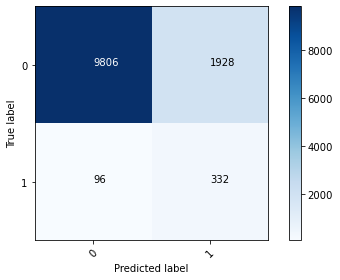

In [13]:
clf=SVC(kernel='rbf', probability=True, C=6, gamma='scale', degree=2)
# Fit model
%time clf.fit(X_train_oversampled_s4, y_train_oversampled_s4)
yhat1 = clf.predict(x_test_s4)

accuracy = accuracy_score(y_test, yhat1)*100
print("Accuracy is of SVM (HyperOpt)", accuracy)

precision = precision_score(y_test, yhat1)*100
print("Precision of SVM (HyperOpt)", precision)

recall = recall_score(y_test, yhat1)*100
print("Recall of SVM (HyperOpt)", recall)

f1 = f1_score(y_test, yhat1)*100
print("F1 score of SVM (HyperOpt)", f1)

labels = [0,1] 
print(classification_report(y_test, yhat1, labels)) #classification report from sklearn
cnf_matrix = confusion_matrix(y_test, yhat1, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) #plot confusion matrix grid
threshold = cnf_matrix.max() / 2 #threshold to define text color
for i in range(cnf_matrix.shape[0]): #print text in grid
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()

### SOLUTION-5 

#### Feature Engineering

In [14]:
clf_rf = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf, n_features_to_select=15, step=1)
rfe = rfe.fit(X_train_scaled, y_train)

In [15]:
print('Chosen best 15 feature by rfe:',X_train.columns[rfe.support_])

Chosen best 15 feature by rfe: Index(['v_5', 'v_34', 'v_38', 'critical_count', 'serious_count', 'minor_count',
       'past_minor', 'time_since_last', 'first_record', 'age_at_inspection',
       'burglary_kde', 'temperature_max', 'humidity', 'precip_intensity',
       'wind_speed'],
      dtype='object')


In [16]:
x_train_s5=rfe.transform(X_train_scaled)
x_test_s5 = rfe.transform(X_test_scaled)

#### Class Imbalance 

In [17]:
sm = SMOTE(random_state = 42)
X_train_oversampled_s5, y_train_oversampled_s5 = sm.fit_sample(x_train_s5, y_train)
pd.Series(y_train_oversampled_s5).value_counts().sort_index()

0    46820
1    46820
Name: class_label, dtype: int64

#### Modeling & prediction 

##### RandomForest (Default parameter)

CPU times: user 24.9 s, sys: 16 ms, total: 25 s
Wall time: 25 s
Accuracy is of RandomForest 95.47771748067751
Precision of RandomForest 35.944700460829495
Recall of RandomForest 36.44859813084112
F1 score of RandomForest 36.19489559164734
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11734
           1       0.36      0.36      0.36       428

    accuracy                           0.95     12162
   macro avg       0.67      0.67      0.67     12162
weighted avg       0.96      0.95      0.95     12162



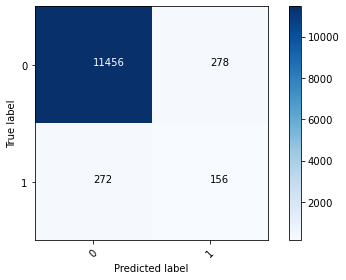

In [22]:
#random forest classifier with n_estimators=10 (default)
classifier_rf = RandomForestClassifier()      
%time classifier_rf = classifier_rf.fit(X_train_oversampled_s5,y_train_oversampled_s5)
yhat1_rf=classifier_rf.predict(x_test_s5)

accuracy_rf = accuracy_score(y_test, yhat1_rf)*100
print("Accuracy is of RandomForest", accuracy_rf)

precision_rf = precision_score(y_test, yhat1_rf)*100
print("Precision of RandomForest", precision_rf)

recall_rf = recall_score(y_test, yhat1_rf)*100
print("Recall of RandomForest", recall_rf)

f1_rf = f1_score(y_test, yhat1_rf)*100
print("F1 score of RandomForest", f1_rf)

labels = [0,1] 
print(classification_report(y_test, yhat1_rf, labels)) #classification report from sklearn
cnf_matrix = confusion_matrix(y_test, yhat1_rf, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) #plot confusion matrix grid
threshold = cnf_matrix.max() / 2 #threshold to define text color
for i in range(cnf_matrix.shape[0]): #print text in grid
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()

##### XGBoost

CPU times: user 3min 3s, sys: 234 ms, total: 3min 3s
Wall time: 1min 32s
Accuracy is of XGBoost 96.76862358164774
Precision of XGBoost 56.86274509803921
Recall of XGBoost 33.8785046728972
F1 score of XGBoost 42.4597364568082
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11734
           1       0.57      0.34      0.42       428

    accuracy                           0.97     12162
   macro avg       0.77      0.66      0.70     12162
weighted avg       0.96      0.97      0.96     12162



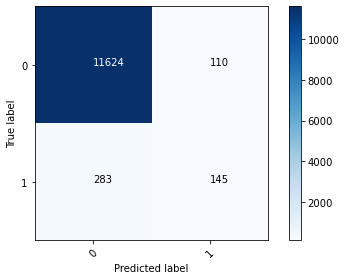

In [20]:
classifier_xgb = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.4,
    #subsample=0.9,
    colsample_bytree=0.6,
    missing=-999,
    random_state=2020,
)

%time classifier_xgb.fit(X_train_oversampled_s5,y_train_oversampled_s5)
yhat1_xgb = classifier_xgb.predict(x_test_s5)

accuracy_xgb = accuracy_score(y_test, yhat1_xgb)*100
print("Accuracy is of XGBoost", accuracy_xgb)

precision_xgb = precision_score(y_test, yhat1_xgb)*100
print("Precision of XGBoost", precision_xgb)

recall_xgb = recall_score(y_test, yhat1_xgb)*100
print("Recall of XGBoost", recall_xgb)

f1_xgb = f1_score(y_test, yhat1_xgb)*100
print("F1 score of XGBoost", f1_xgb)

labels = [0,1] 
print(classification_report(y_test, yhat1_xgb, labels)) #classification report from sklearn
cnf_matrix = confusion_matrix(y_test, yhat1_xgb, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) #plot confusion matrix grid
threshold = cnf_matrix.max() / 2 #threshold to define text color
for i in range(cnf_matrix.shape[0]): #print text in grid
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.867


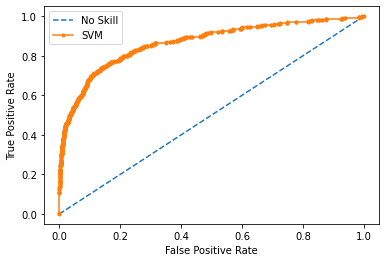

In [21]:
# generate a no skill prediction (majority class)

lr_probs = classifier_xgb.predict_proba(x_test_s5)
ns_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only

lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='SVM')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend

plt.legend()
# show the plot
plt.show()